In [62]:
import os
import sys 
import wave
import time
from scipy.signal import spectrogram
from scipy.io.wavfile import read
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Audio
import librosa
import tensorflow as tf
import datetime
import pandas as pd
%pylab inline
from tensorflow.contrib.layers import convolution2d, conv2d, batch_norm, max_pool2d, fully_connected, l2_regularizer, dropout, flatten


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['flatten', 'rate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
DATA_PATH = "/root/notebooks/musicdata/"

In [3]:
sound_file = os.path.join(DATA_PATH, "audiosamples", "short_206377.wav")
# sound_file = "./short_206377.wav"
samples, rate = librosa.load(sound_file)
Audio(samples, rate=rate)

# Sound as 1D-Signal

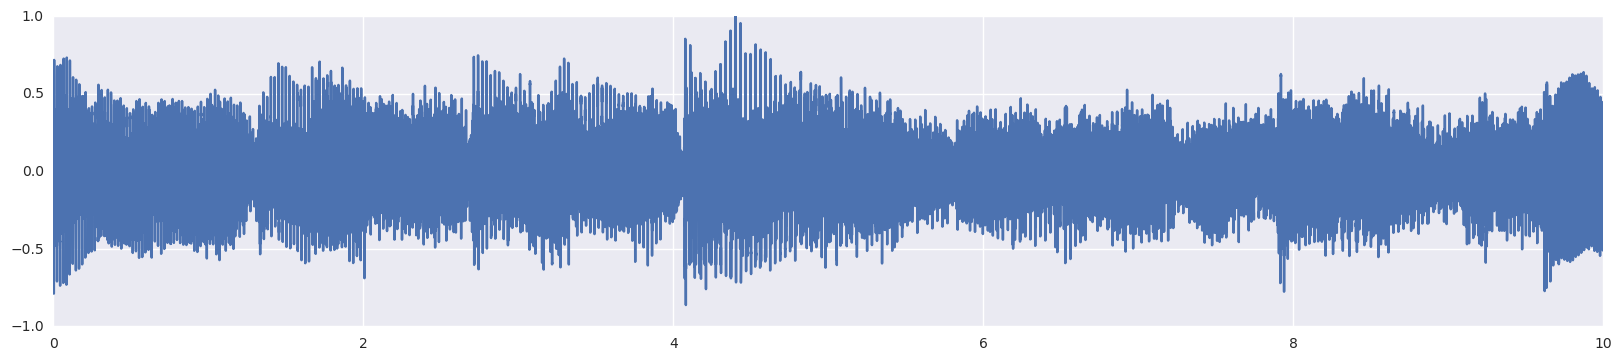

In [4]:
plt.figure(figsize=(20,4))
pylab.plot(np.linspace(0, len(samples) / rate, len(samples)), samples)
pylab.show()

In [5]:
S = librosa.feature.melspectrogram(samples, sr=rate, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

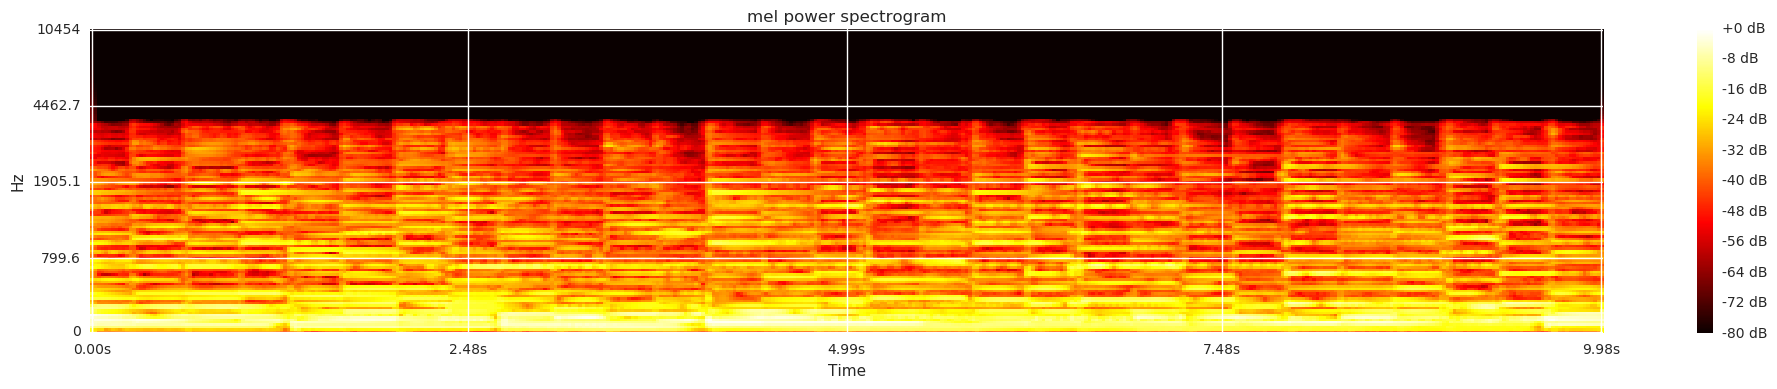

In [6]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=rate, x_axis='time', y_axis='mel', cmap='hot')

plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Загрузим данные:

In [7]:
for i in range(1,8):
    if i == 1:
        X = np.load(os.path.join(DATA_PATH, "spectrograms", "spectrograms{}.pcl".format(i)))
    elif i == 7:
        X_test = np.load(os.path.join(DATA_PATH, "spectrograms", "spectrograms{}.pcl".format(i)))
    else:
        X = np.vstack((X, np.load(os.path.join(DATA_PATH, "spectrograms", "spectrograms{}.pcl".format(i)))))
    print("Unpickled spectrograms{}.pcl".format(i))

Unpickled spectrograms1.pcl
Unpickled spectrograms2.pcl
Unpickled spectrograms3.pcl
Unpickled spectrograms4.pcl
Unpickled spectrograms5.pcl
Unpickled spectrograms6.pcl
Unpickled spectrograms7.pcl


In [8]:
X.astype(np.float32, copy=False)
X_test.astype(np.float32, copy=False)

array([[[-48.17320251, -35.18611908, -20.62840652, ..., -22.23636436,
         -25.78302383, -20.09692574],
        [-31.98403168, -25.7950592 , -16.28125763, ..., -20.75248146,
         -13.27737236,  -7.95897341],
        [-22.91043854, -16.31326675, -13.49856567, ..., -17.34462547,
          -4.97483253,  -1.83852863],
        ..., 
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -80.        ],
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -80.        ],
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -80.        ]],

       [[-12.0765667 , -18.11872482, -29.71771812, ..., -29.41243172,
         -29.71467209, -18.86766243],
        [ -2.22701216,  -6.31130552, -16.35346603, ...,  -8.4231863 ,
          -5.18129444,  -6.65838957],
        [ -4.17789125,  -6.28821754, -13.74742222, ...,  -2.16977239,
          -2.35776615,  -8.85616016],
        ...,

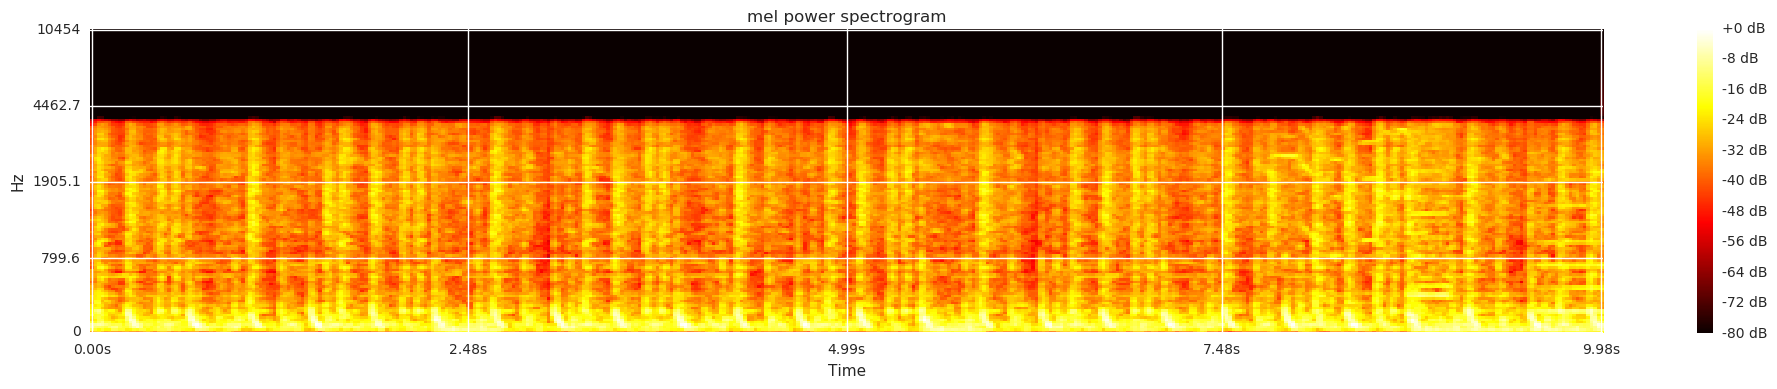

In [9]:
plt.figure(figsize=(20,4))
librosa.display.specshow(X[6], sr=rate, x_axis='time', y_axis='mel', cmap='hot')

plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [10]:
with open(os.path.join(DATA_PATH, "train_genres.txt"), "r") as train:
    genres = list(map(lambda x: x[:-1], train.readlines()))
unique_genres = np.unique(genres)

In [11]:
unique_genres

array(['african', 'alternative', 'amerfolk', 'asiapop', 'balkan', 'bard',
       'blues', 'bollywood', 'celtic', 'children', 'classical', 'conjazz',
       'country', 'dance', 'disco', 'dnb', 'dub', 'dubstep', 'eastern',
       'electronics', 'estrada', 'eurofolk', 'experimental', 'folk',
       'funk', 'hardcore', 'holiday', 'house', 'indie', 'industrial',
       'jazz', 'jewish', 'latinfolk', 'lounge', 'meditation', 'metal',
       'modern', 'musical', 'newage', 'newwave', 'other', 'pop', 'prog',
       'punk', 'rap', 'reggae', 'reggaeton', 'relax', 'rnb', 'rnr', 'rock',
       'rusfolk', 'rusrap', 'rusrock', 'shanson', 'ska', 'soul',
       'soundtrack', 'spiritual', 'spoken', 'sport', 'techno', 'tradjazz',
       'trance', 'ukrrock', 'urban', 'vocal'], 
      dtype='<U12')

In [12]:
y = np.array(list(map(lambda x: list(unique_genres).index(x),genres)))

In [13]:
y[:50]

array([ 5, 13, 47, 50, 44, 57, 19, 41, 52, 41, 41, 52, 58, 20, 41, 43, 54,
       54, 48, 10, 19, 41, 41, 44, 50,  1, 41, 50, 54, 19, 27, 50, 41, 20,
       41, 41, 50, 19, 41, 19, 28, 50, 30, 34, 52,  1, 50, 41, 41, 20])

Посмотрим на распределение классов в трейновой выборке:

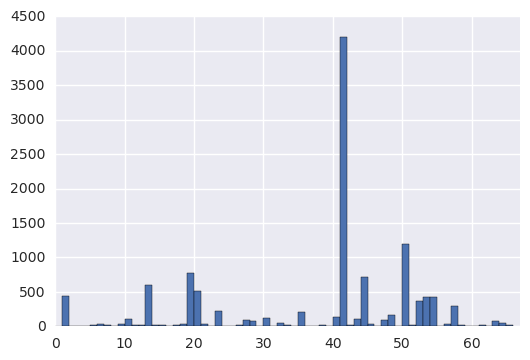

In [14]:
plt.hist(y, bins=np.arange(len(unique_genres)))
plt.xlim([0, len(unique_genres)])
plt.show()

In [15]:
len(y[y == 41])

4204

In [16]:
unique_genres[41]

'pop'

Как видно, датасет сильно несбалансированный: примеров жанра 'pop' в нем гораздо больше, чем всех остальных.

In [21]:
perm = np.random.permutation(len(y))
X, y = X[perm], y[perm]

X_train, X_valid = X[:10000], X[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [22]:
X_train.shape

(10000, 128, 431)

In [23]:
X_valid.shape

(2000, 128, 431)

# KNN

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=7, n_jobs=8, algorithm='kd_tree')

clf = clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])))

print(accuracy_score(y_valid, y_val_pred))

0.2805


# Fully-connected NN

In [106]:
def get_batches(X_, y_, batch_size, test=False):
    """Generate batches of data."""
    current_batch_num = 0
    train_size = len(X_)
    if not test:
        perm = np.random.permutation(np.arange(train_size))
        X_ = X_[perm]
        y_ = y_[perm]
    while current_batch_num * batch_size < train_size:
        start = current_batch_num * batch_size
        end = (current_batch_num + 1) * batch_size
        yield X_[start: end], y_[start: end]
        current_batch_num += 1

In [107]:
batch_size = 250
hidden_size1 = 256
hidden_size2 = 256
num_epochs = 10
num_items = len(unique_genres)

In [72]:
g = tf.Graph()
with g.as_default():
    inputs = tf.placeholder(tf.float32, shape=(batch_size, 128*431))
    labels = tf.placeholder(tf.int32, shape=(batch_size))
    out1 = fully_connected(inputs, num_outputs=hidden_size1,
                           weights_regularizer=l2_regularizer(0.8))
    out2 = fully_connected(out1, num_outputs=hidden_size2,
                           weights_regularizer=l2_regularizer(0.8))
    logits = fully_connected(out2, num_outputs=num_items, activation_fn=None,
                             weights_regularizer=l2_regularizer(0.8))
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels))
    predicted_labels = tf.to_int32(tf.argmax(logits, 1))
    accuracy = tf.reduce_sum(tf.to_int32(tf.equal(predicted_labels, labels))) / batch_size
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [73]:
with g.as_default():
    session = tf.Session()
    session.run(tf.initialize_all_variables())
    for epoch in range(num_epochs):
        batch_costs = []
        batch_accuracies = []
        print("Starting epoch {}...".format(epoch), end=" ")
        start_time = time.time()
        for (inputs_batch, labels_batch) in get_batches(X_train.reshape((X_train.shape[0],-1)), y_train, batch_size):
            if len(inputs_batch) < batch_size:
                continue
            feedDict_train = {inputs: inputs_batch, labels: labels_batch}
            start = datetime.datetime.now()
            _, batch_cost, train_acc = session.run([optimizer, loss, accuracy], feed_dict=feedDict_train)
            batch_costs.append(batch_cost)
            batch_accuracies.append(train_acc)
        batch_costs_val = []
        batch_accuracies_val = []
        for (inputs_batch_valid, labels_batch_valid) in get_batches(X_valid.reshape((X_valid.shape[0],-1)), y_valid, batch_size):
            if len(inputs_batch_valid) < batch_size:
                continue
            feedDict_valid = {inputs: inputs_batch_valid, labels: labels_batch_valid}
            _, val_loss, batch_acc, predicted = session.run([optimizer, loss, accuracy, predicted_labels], feed_dict=feedDict_valid)
            batch_accuracies_val.append(batch_acc)
            batch_costs_val.append(val_loss)
        print(predicted)
        print("Done.\nAvg train cost: {:.3f}, accuracy: {:.3f}. Avg val cost: {:.3f}, val accuracy: {:.3f}, time: {}".format(
              np.mean(batch_costs), np.mean(batch_accuracies), np.mean(batch_costs_val),
              np.mean(batch_accuracies_val), time.time() - start_time))
    session.close()

Starting epoch 0... [35 41 35 41 41 41 41 41 35 41 41 41 35 41 41 35 41 35 35 35 35 41 41 41 41
 41 41 35 35 41 35 41 35 35 35 35 41 41 41 35 35 35 35 35 35 41 35 35 41 35
 35 35 35 41 41 35 35 35 35 41 35 35 41 41 35 41 41 35 35 41 35 41 41 41 41
 35 35 35 41 41 41 35 41 41 35 35 41 35 35 41 35 41 35 41 35 35 35 35 35 41
 41 35 41 41 41 35 41 35 41 35 41 41 41 35 41 41 35 41 35 41 41 35 41 41 41
 41 41 41 35 41 41 41 41 35 41 35 41 41 41 41 41 35 41 35 35 41 35 41 35 41
 41 41 35 41 41 41 35 35 35 41 35 41 35 35 41 41 35 41 35 41 35 41 35 35 41
 41 41 35 35 41 41 41 41 41 41 35 35 35 41 35 41 41 35 41 41 41 35 41 35 35
 41 41 35 35 41 41 35 41 35 41 41 41 41 41 35 41 41 41 35 41 41 35 41 35 41
 41 41 41 41 41 35 41 35 35 41 41 41 35 41 35 41 41 41 35 41 41 41 35 35 41]
Done.
Avg train cost: 1876.145, accuracy: 0.126. Avg val cost: 746.690, val accuracy: 0.194, time: 1.649193525314331
Starting epoch 1... [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20

# CNN

In [108]:
batch_size = 25
n_filters1 = 64
n_filters2 = 128
n_filters3 = 256
n_filters4 = 256
num_epochs = 90
num_items = len(unique_genres)

In [109]:
# inputs
g = tf.Graph()
with g.as_default():
    inputs = tf.placeholder(tf.float32, shape=(batch_size, 96, 431))
    labels = tf.placeholder(tf.int32, shape=(batch_size))
    is_training = tf.placeholder(tf.bool, shape=())
    print(inputs_reshape.get_shape())
    inputs_reshape = tf.transpose(inputs, perm=(0, 2, 1))
    inputs_reshape = tf.expand_dims(inputs_reshape, 3)
    print(inputs_reshape.get_shape())
    # 1st conv layer
    outputs1 = convolution2d(inputs_reshape, n_filters1, kernel_size=[4, 4], activation_fn=tf.nn.relu)
    
    # 1st max-pooling layer
    print(outputs1.get_shape())
    outputs2 = max_pool2d(outputs1, kernel_size=[2, 2], stride=[2, 2])
    # 2nd conv layer
    print(outputs2.get_shape())
    outputs3 = convolution2d(outputs2, n_filters2, kernel_size=[4, 4], activation_fn=tf.nn.relu) 
    # 2nd max-pooling layer
    print(outputs3.get_shape())
    outputs4 = max_pool2d(outputs3, kernel_size=[2, 2], stride=[2, 2])
    
    # 3rd conv layer
    print(outputs2.get_shape())
    outputs5 = convolution2d(outputs4, n_filters3, kernel_size=[4, 4], activation_fn=tf.nn.relu)

    # 3rd max-pooling layer
    print(outputs5.get_shape())
    outputs6 = max_pool2d(outputs5, kernel_size=[2, 2], stride=[2, 2])
    
    # 4th conv layer
    print(outputs2.get_shape())
    outputs7 = convolution2d(outputs6, n_filters4, kernel_size=[4, 4], activation_fn=tf.nn.relu)
   

    # global temporal pooling layer
    global_outputs = max_pool2d(outputs7, kernel_size=[outputs7.get_shape()[1].value, 1])

    print(global_outputs.get_shape())
    logits = fully_connected(tf.reshape(global_outputs, (batch_size, -1)), num_outputs=num_items, activation_fn=None,
                             weights_regularizer=l2_regularizer(0.8))

    # logits_reshape = tf.reshape(logits, shape=(batch_size, -1))
    print(logits.get_shape())
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels))
    predicted_labels = tf.to_int32(tf.argmax(logits, 1))
    accuracy = tf.reduce_sum(tf.to_int32(tf.equal(predicted_labels, labels))) / batch_size
    optimizer = tf.train.AdamOptimizer().minimize(loss)

(25, 431, 96, 1)
(25, 431, 96, 1)
(25, 431, 96, 64)
(25, 215, 48, 64)
(25, 215, 48, 128)
(25, 215, 48, 64)
(25, 107, 24, 256)
(25, 215, 48, 64)
(25, 1, 6, 256)
(25, 67)


In [110]:
with g.as_default():
    session = tf.Session()
    session.run(tf.initialize_all_variables())
    for epoch in range(num_epochs):
        batch_costs = []
        batch_accuracies = []
        print("Starting epoch {}...".format(epoch), end=" ")
        start_time = time.time()
        for (inputs_batch, labels_batch) in get_batches(X_train[:, :96,:], y_train, batch_size):
            if len(inputs_batch) < batch_size:
                continue
            feedDict_train = {inputs: inputs_batch, labels: labels_batch,
                              is_training: True}
            start = datetime.datetime.now()
            _, batch_cost, train_acc = session.run([optimizer, loss, accuracy], feed_dict=feedDict_train)
            batch_costs.append(batch_cost)
            batch_accuracies.append(train_acc)
        batch_costs_val = []
        batch_accuracies_val = []
        for (inputs_batch_valid, labels_batch_valid) in get_batches(X_valid[:, :96,:], y_valid, batch_size):
            if len(inputs_batch_valid) < batch_size:
                continue
            feedDict_valid = {inputs: inputs_batch_valid, labels: labels_batch_valid,
                              is_training: False}
            _, val_loss, batch_acc, predicted = session.run([optimizer, loss, accuracy, predicted_labels], feed_dict=feedDict_valid)
            batch_accuracies_val.append(batch_acc)
            batch_costs_val.append(val_loss)
        print(predicted)
        print("Done.\nAvg train cost: {:.3f}, accuracy: {:.3f}. Avg val cost: {:.3f}, val accuracy: {:.3f}, time: {}".format(
              np.mean(batch_costs), np.mean(batch_accuracies), np.mean(batch_costs_val),
              np.mean(batch_accuracies_val), time.time() - start_time))

Starting epoch 0... [41 41 41 41 41 50 41 44 41 41 44 41 41 41 41 41 41 41 41 41 50 41 41 50 41]
Done.
Avg train cost: 2.728, accuracy: 0.352. Avg val cost: 2.510, val accuracy: 0.361, time: 77.81625747680664
Starting epoch 1... [41 41 41 41 50 41 41 41 41 41 41 44 41 41 41 41 10 41 41 41 41 41 41 41 41]
Done.
Avg train cost: 2.387, accuracy: 0.376. Avg val cost: 2.354, val accuracy: 0.370, time: 76.82253217697144
Starting epoch 2... [41 50 41 41 41 41 41 41 50 41 35 19 52 41 41 41 41 50 41 41 19 41 41 50 41]
Done.
Avg train cost: 2.249, accuracy: 0.395. Avg val cost: 2.216, val accuracy: 0.396, time: 76.79590392112732
Starting epoch 3... [50 57 41 41 41 41 44 41 57 41 41 41 41 41 41 41 41 52 41 41 50 44 41 41 41]
Done.
Avg train cost: 2.142, accuracy: 0.412. Avg val cost: 2.107, val accuracy: 0.420, time: 76.71115970611572
Starting epoch 4... [41 41 44 41 41 41 50 50 41 41 41 41 41 20 44 41 41 41 41 50 41 41 41 50 13]
Done.
Avg train cost: 2.049, accuracy: 0.425. Avg val cost: 1.980, 

KeyboardInterrupt: 

In [111]:
len(X_test)

2000

In [112]:
y_pred = []
with g.as_default():
    for (test_batch, _) in get_batches(X_test[:, :96,:], y_train, batch_size, test=True):
        if len(test_batch) < batch_size:
            break
        feedDict = {inputs: test_batch, is_training: False}
        start = datetime.datetime.now()
        pred = session.run([predicted_labels], feed_dict=feedDict)
        y_pred.extend(list(pred[0]))

In [113]:
len(y_pred)

2000

In [114]:
[41, 41, 41, 41, 41, 41, 54, 41, 50, 53, 41, 1, 1, 41, 50]

[41, 41, 41, 41, 41, 41, 54, 41, 50, 53, 41, 1, 1, 41, 50]

In [115]:
y_pred[:15]

[41, 53, 41, 41, 50, 41, 54, 56, 41, 53, 41, 1, 35, 41, 50]

In [116]:
pred_genres = list(map(lambda x: unique_genres[x], y_pred))

In [117]:
pd.DataFrame(data={'Category': pred_genres, 'Id': 12000 + np.arange(2000)}).to_csv('answer.csv', index=False)

# Filters

['Conv/weights:0', 'Conv/biases:0', 'Conv_1/weights:0', 'Conv_1/biases:0', 'Conv_2/weights:0', 'Conv_2/biases:0', 'Conv_3/weights:0', 'Conv_3/biases:0', 'fully_connected/weights:0', 'fully_connected/biases:0', 'beta1_power:0', 'beta2_power:0', 'Conv/weights/Adam:0', 'Conv/weights/Adam_1:0', 'Conv/biases/Adam:0', 'Conv/biases/Adam_1:0', 'Conv_1/weights/Adam:0', 'Conv_1/weights/Adam_1:0', 'Conv_1/biases/Adam:0', 'Conv_1/biases/Adam_1:0', 'Conv_2/weights/Adam:0', 'Conv_2/weights/Adam_1:0', 'Conv_2/biases/Adam:0', 'Conv_2/biases/Adam_1:0', 'Conv_3/weights/Adam:0', 'Conv_3/weights/Adam_1:0', 'Conv_3/biases/Adam:0', 'Conv_3/biases/Adam_1:0', 'fully_connected/weights/Adam:0', 'fully_connected/weights/Adam_1:0', 'fully_connected/biases/Adam:0', 'fully_connected/biases/Adam_1:0']


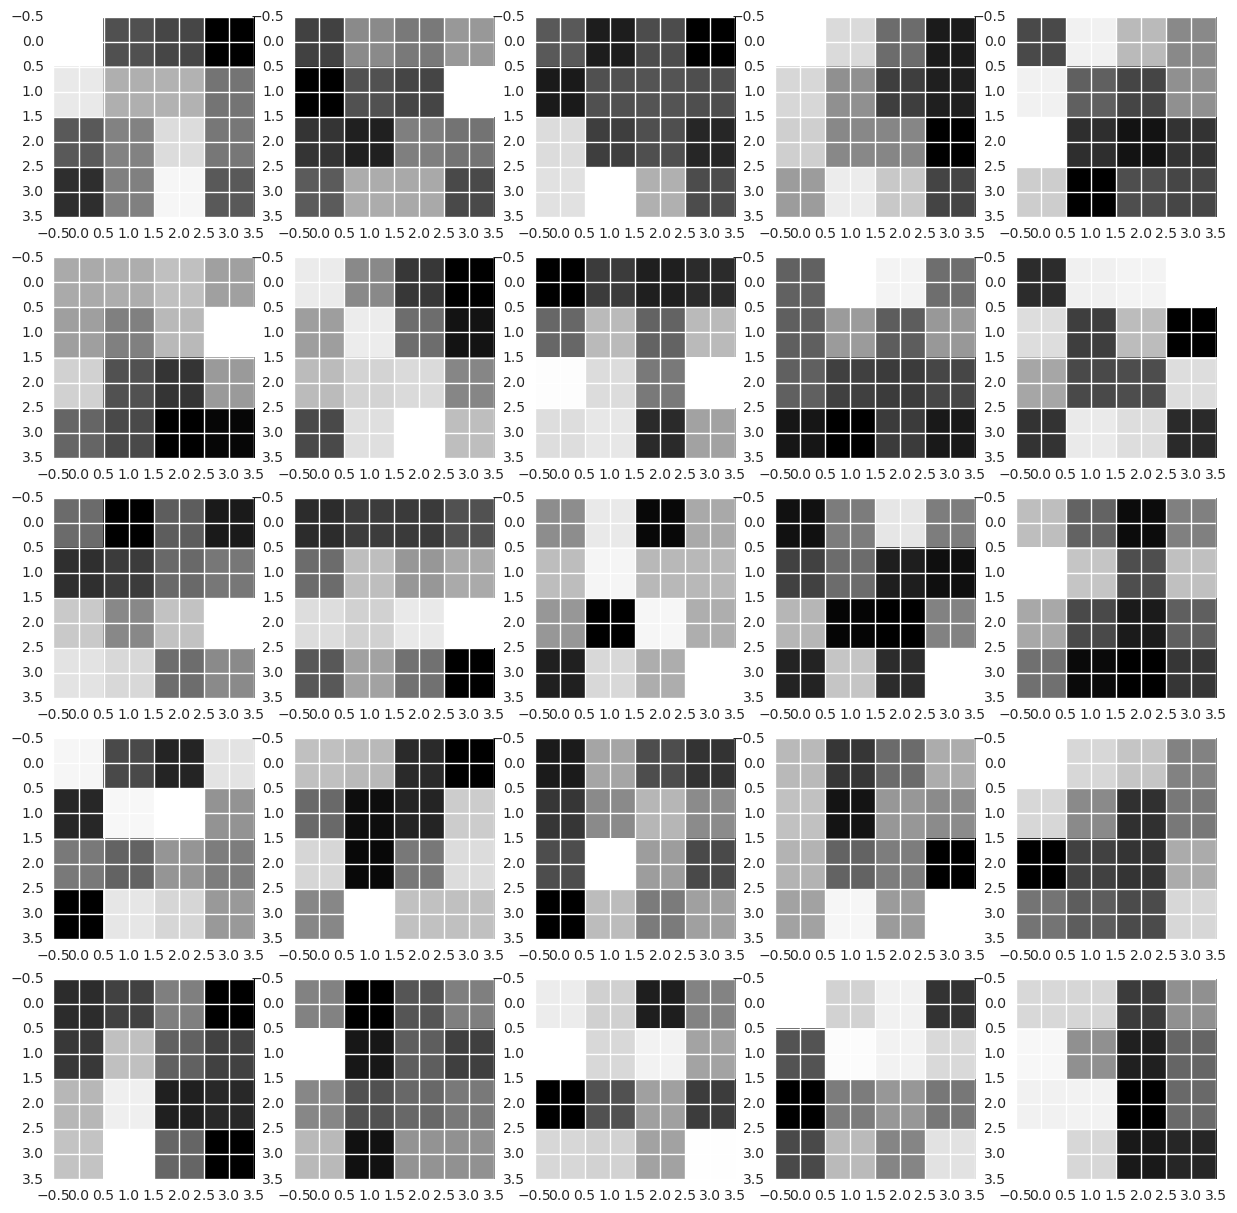

In [118]:
with g.as_default():
    print([v.name for v in tf.all_variables()])
    W = [v for v in tf.all_variables() if v.name == "Conv/weights:0"][0]
    W_values = session.run(W)
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(W_values[:, :, 0, i * 5 + j], interpolation='nearest', cmap='gray')
    plt.show()

# Maps of tracks by SVD and tSNE

In [119]:
from sklearn.manifold import TSNE

In [122]:
all_last_hidden = []
with g.as_default():
    for (test_batch, test_labels) in get_batches(X, y, batch_size, test=True):
        if len(test_batch) < batch_size:
            break
        feedDict = {inputs: test_batch[:, :96, :], labels: test_labels}
        last_hidden = session.run(global_outputs, feed_dict=feedDict).reshape((batch_size, -1))
        all_last_hidden.extend(last_hidden)
all_last_hidden = np.array(all_last_hidden)

In [123]:
all_last_hidden.shape

(12000, 1536)

In [124]:
model = TSNE(n_components=2, random_state=42)
X_tsne = model.fit_transform(all_last_hidden[:1000]) 

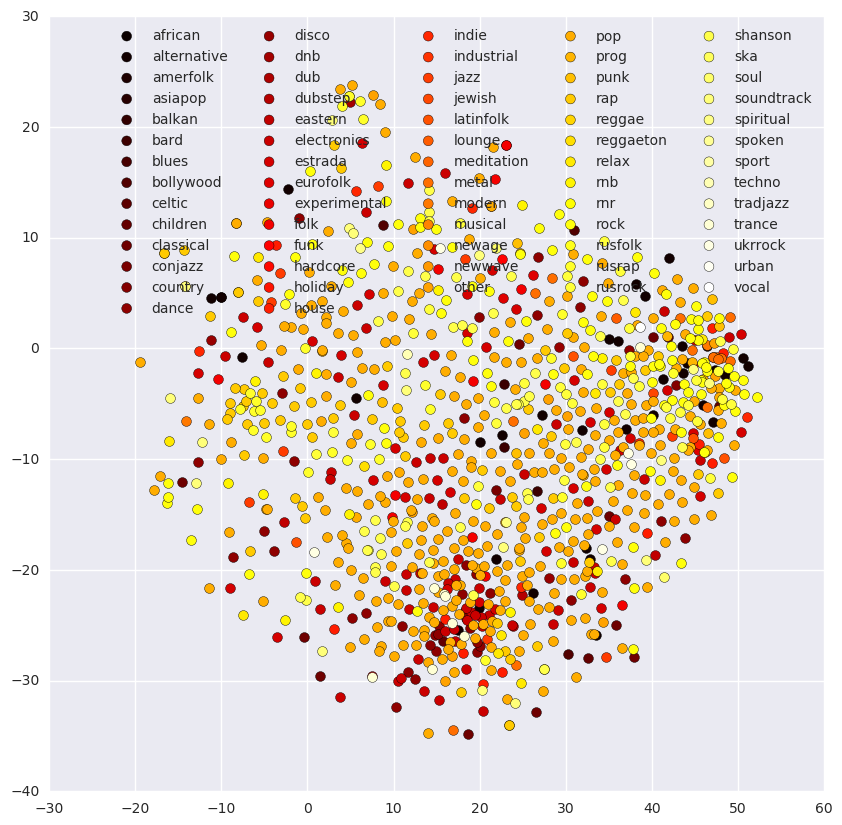

In [125]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(unique_genres)))

for idx, genre in enumerate(unique_genres):
    idx_ = np.where(y[:1000] == idx)
    pylab.scatter(X_tsne[idx_,0], X_tsne[idx_,1], c=colors[idx], cmap=cm.hot, label=genre, s=50)
pylab.legend(loc=0, ncol=5)